In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 8
plt.rcParams['legend.fontsize'] = 'xx-large'
plt.rcParams['axes.titlesize'] = 20

# Instantaneous currents

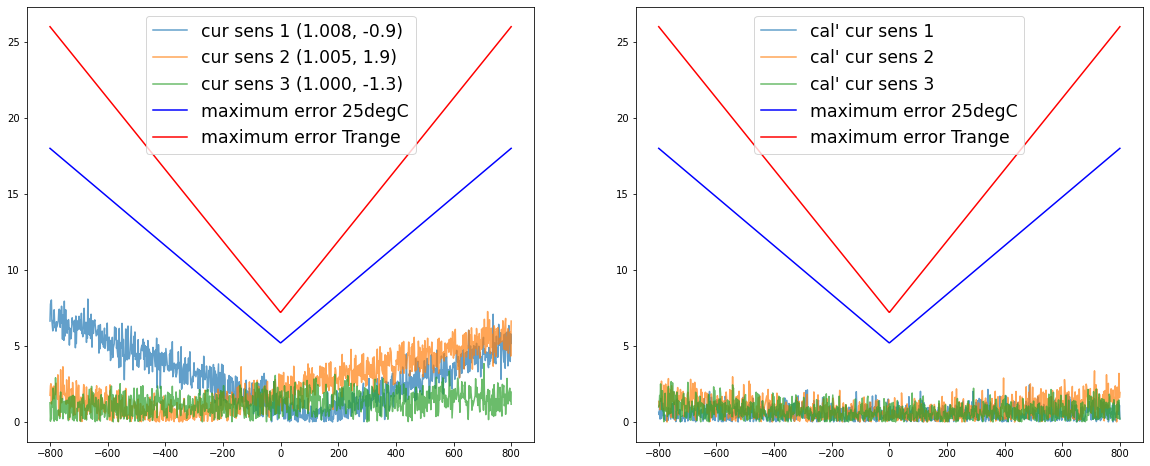

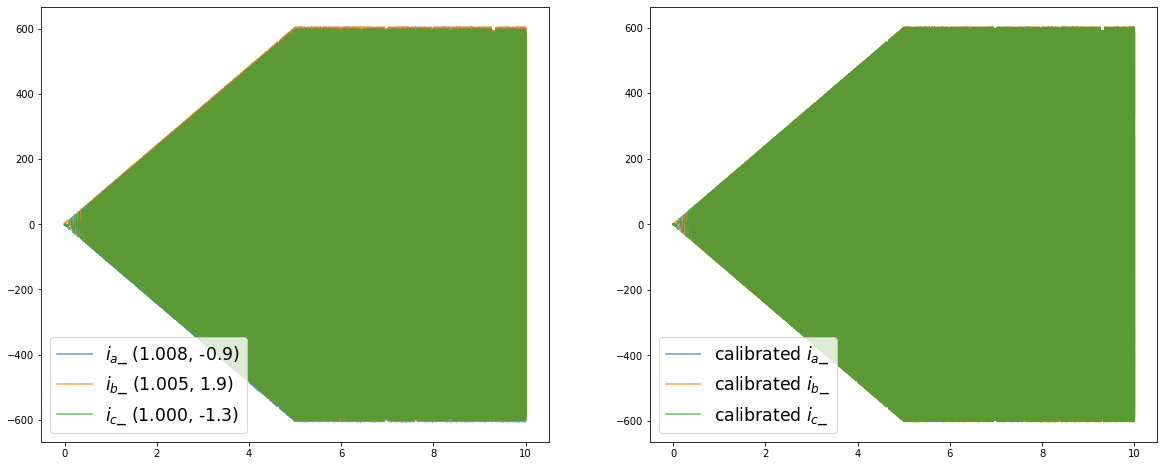

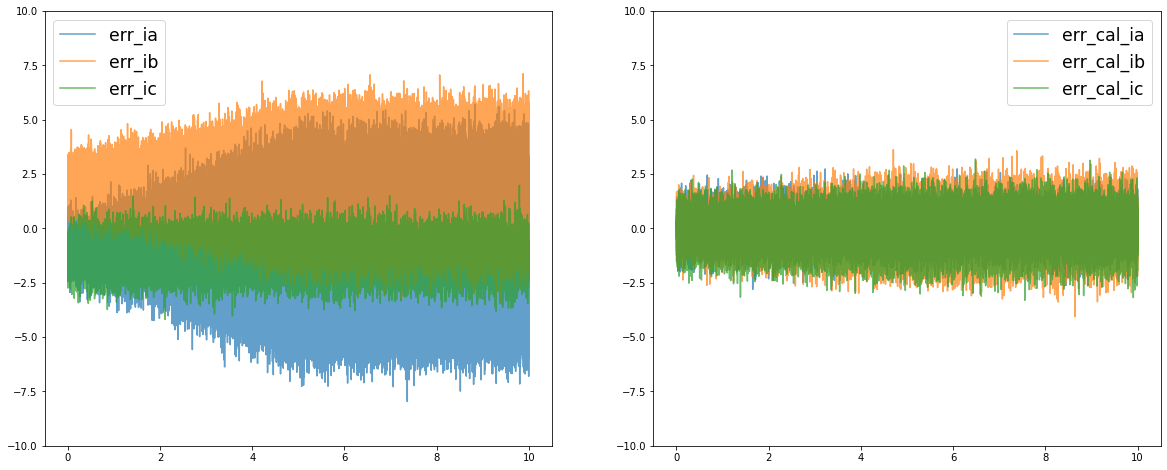

In [2]:
class CurrentSource():

    def __init__(self, gain_std, offset_std, noise_std):
        
        self.gain = np.random.normal(1, gain_std)
        self.offset = np.random.normal(0, offset_std)
        self.noise_std = noise_std
        
        self.get_source_current = np.vectorize(self._get_source_current)
    
    def _get_source_current(self, demand_current):
         
        return demand_current*self.gain + self.offset + np.random.normal(0, self.noise_std)
    
class CurrentSensor():
    
    cursens_confidence_factor = 4
    cursens_range = 800
    cursens_max_offset_25degC_err = 5.2
    cursens_max_range_25degC_err = 18
    cursens_max_offset_err = 7.2
    cursens_max_range_err = 26
    cursens_max_gain_25degC_err = (cursens_max_range_25degC_err - cursens_max_offset_25degC_err)/cursens_range # max **absolute** gain error
    cursens_max_gain_err = (cursens_max_range_err - cursens_max_offset_err)/cursens_range # max **absolute** gain error
    cursens_noise_pk2pk = 2
    
    # use errors @ 25degC until a temperature model is implemented
    gain_std = cursens_max_gain_25degC_err/cursens_confidence_factor
    offset_std = cursens_max_offset_25degC_err/cursens_confidence_factor       

    noise_std = cursens_noise_pk2pk/3

    adc_range = 2000
    adc_res = 12
    resolution = adc_range/(2**adc_res)
    
    def __init__(self):
  
        self.gain = np.random.normal(1, self.gain_std)
        self.offset = np.random.normal(0, self.offset_std)
    
        self.get_measurement = np.vectorize(self._get_measurement)
        self.get_calibrated_measurement = np.vectorize(self._get_calibrated_measurement)
        
        # 2-point calibration
        nb_of_samples = 30
        tur = 4 
        c_source = CurrentSource(0, 0, self.noise_std/tur)
        
        # Setpoint 1
        current_setpoint_1 = -120
        current_setpoints_1 = current_setpoint_1*np.ones(nb_of_samples)
        actual_setpoints_1 = c_source.get_source_current(current_setpoints_1)
        measurement_1 = self.get_measurement(actual_setpoints_1).mean()
        
        # Setpoint 2
        current_setpoint_2 = 120
        current_setpoints_2 = current_setpoint_2*np.ones(nb_of_samples)
        actual_setpoints_2 = c_source.get_source_current(current_setpoints_2)
        measurement_2 = self.get_measurement(actual_setpoints_2).mean()
        
        self.calibration_gain = (current_setpoint_2 - current_setpoint_1)/(measurement_2 - measurement_1)
        self.calibration_offset = current_setpoint_1 - self.calibration_gain*measurement_1
        
    def _get_measurement(self, true_current):
        return self.resolution*np.round((true_current*self.gain + self.offset + np.random.normal(0, self.noise_std))/self.resolution)
    
    def _get_calibrated_measurement(self, true_current):
        return self.get_measurement(true_current)*self.calibration_gain + self.calibration_offset

cs1 = CurrentSensor()
cs2 = CurrentSensor()
cs3 = CurrentSensor()

N = 40000
tmax = 10
t = np.linspace(0, tmax, N)
w = 1500*t/tmax # rad/s
Ipk_ = 600
#stator_field_angle = 2*np.pi*t/tmax-np.pi/2
Ipk = np.concatenate([np.arange(0, Ipk_, Ipk_/(N//2)), Ipk_*np.ones(N//2)])
stator_field_angle = np.concatenate([np.pi/2*np.ones(N//2), np.arange(np.pi/2, np.pi, np.pi/2/(N//2))])
ia = Ipk*np.cos(w*t + stator_field_angle)
ib = Ipk*np.cos(w*t - 2*np.pi/3 + stator_field_angle)
ic = Ipk*np.cos(w*t - 4*np.pi/3 + stator_field_angle)

ia_ = cs1.get_measurement(ia)
ib_ = cs2.get_measurement(ib)
ic_ = cs3.get_measurement(ic)

ia_c = cs1.get_calibrated_measurement(ia)
ib_c = cs2.get_calibrated_measurement(ib)
ic_c = cs3.get_calibrated_measurement(ic)

i = np.linspace(-800, 800, 1000)
max_25degC_err = np.abs(
    (CurrentSensor.cursens_max_range_25degC_err - CurrentSensor.cursens_max_offset_25degC_err)*i/CurrentSensor.cursens_range
) + CurrentSensor.cursens_max_offset_25degC_err
max_err = np.abs(
    (CurrentSensor.cursens_max_range_err - CurrentSensor.cursens_max_offset_err)*i/CurrentSensor.cursens_range
) + CurrentSensor.cursens_max_offset_err
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(i, np.abs(cs1.get_measurement(i) - i), label = r"cur sens 1 ({:.3f}, {:.1f})".format(cs1.gain, cs1.offset), alpha=0.7)
ax.plot(i, np.abs(cs2.get_measurement(i) - i), label = r"cur sens 2 ({:.3f}, {:.1f})".format(cs2.gain, cs2.offset), alpha=0.7)
ax.plot(i, np.abs(cs3.get_measurement(i) - i), label = r"cur sens 3 ({:.3f}, {:.1f})".format(cs3.gain, cs3.offset), alpha=0.7)
ax.plot(i, np.abs(max_25degC_err), label = r"maximum error 25degC", color = 'blue')
ax.plot(i, np.abs(max_err), label = r"maximum error Trange", color = 'red')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(i, np.abs(cs1.get_calibrated_measurement(i) - i), label = r"cal' cur sens 1", alpha=0.7)
ax.plot(i, np.abs(cs2.get_calibrated_measurement(i) - i), label = r"cal' cur sens 2", alpha=0.7)
ax.plot(i, np.abs(cs3.get_calibrated_measurement(i) - i), label = r"cal' cur sens 3", alpha=0.7)
ax.plot(i, np.abs(max_25degC_err), label = r"maximum error 25degC", color = 'blue')
ax.plot(i, np.abs(max_err), label = r"maximum error Trange", color = 'red')
ax.legend()

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, ia_, label = r"$i_a$_ ({:.3f}, {:.1f})".format(cs1.gain, cs1.offset), alpha=0.7)
ax.plot(t, ib_, label = r"$i_b$_ ({:.3f}, {:.1f})".format(cs2.gain, cs2.offset), alpha=0.7)
ax.plot(t, ic_, label = r"$i_c$_ ({:.3f}, {:.1f})".format(cs3.gain, cs3.offset), alpha=0.7)
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(t, ia_c, label = r"calibrated $i_a$_", alpha=0.7)
ax.plot(t, ib_c, label = r"calibrated $i_b$_", alpha=0.7)
ax.plot(t, ic_c, label = r"calibrated $i_c$_", alpha=0.7)
ax.legend()

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, ia_ - ia, label = "err_ia", alpha=0.7)
ax.plot(t, ib_ - ib, label = "err_ib", alpha=0.7)
ax.plot(t, ic_ - ic, label = "err_ic", alpha=0.7)
ax.set_ylim(-10, 10)
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(t, ia_c - ia, label = "err_cal_ia", alpha=0.7)
ax.plot(t, ib_c - ib, label = "err_cal_ib", alpha=0.7)
ax.plot(t, ic_c - ic, label = "err_cal_ic", alpha=0.7)
ax.set_ylim(-10, 10)
ax.legend()

# Clarke $\alpha\beta\gamma$-currents

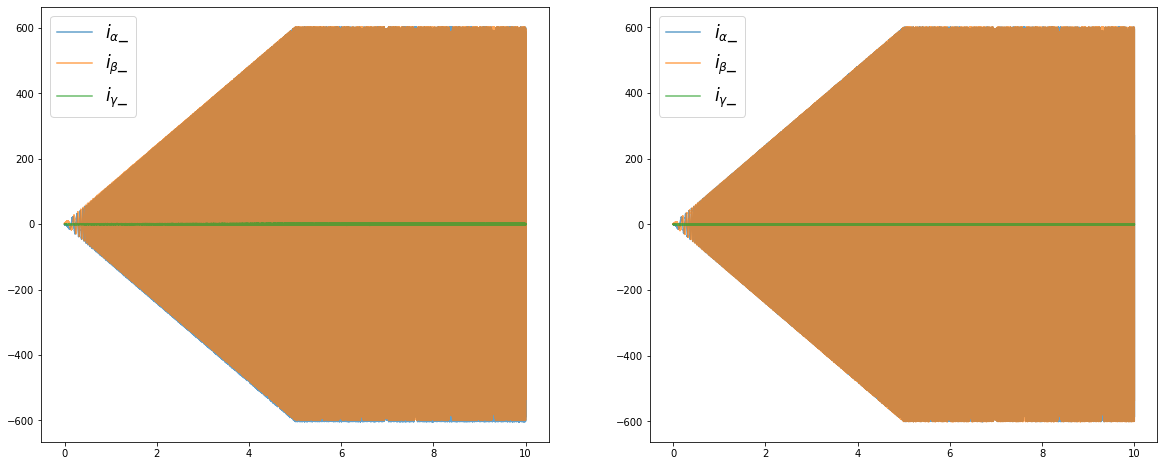

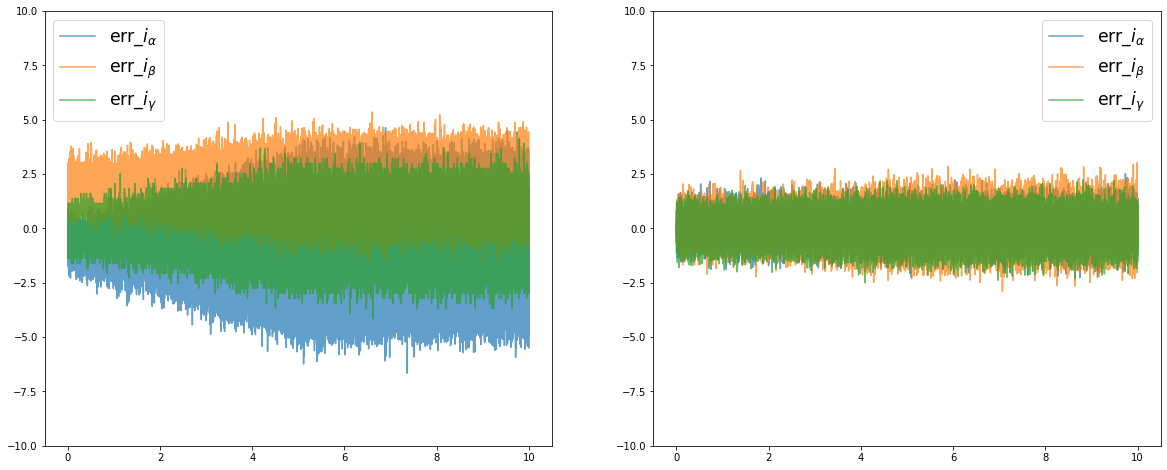

In [3]:
K_C = 2/3*np.array([
    [           1,         -1/2,          -1/2],
    [           0, np.sqrt(3)/2, -np.sqrt(3)/2], 
    [np.sqrt(2)/2, np.sqrt(2)/2,  np.sqrt(2)/2],
])

ialpha, ibeta, igamma = np.matmul(
    K_C, np.array([
        ia,
        ib, 
        ic,
    ])
)
ialpha_, ibeta_, igamma_ = np.matmul(
    K_C, np.array([
        ia_,
        ib_, 
        ic_,
    ])
)
ialpha_c, ibeta_c, igamma_c = np.matmul(
    K_C, np.array([
        ia_c,
        ib_c, 
        ic_c,
    ])
)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, ialpha_, label = r"$i_{{\alpha}}$_", alpha=0.7)
ax.plot(t, ibeta_, label = r"$i_{{\beta}}$_", alpha=0.7)
ax.plot(t, igamma_, label = r"$i_{{\gamma}}$_", alpha=0.7)
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(t, ialpha_c, label = r"$i_{{\alpha}}$_", alpha=0.7)
ax.plot(t, ibeta_c, label = r"$i_{{\beta}}$_", alpha=0.7)
ax.plot(t, igamma_c, label = r"$i_{{\gamma}}$_", alpha=0.7)
ax.legend()

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, ialpha_ - ialpha, label = r"err_$i_{{\alpha}}$", alpha=0.7)
ax.plot(t, ibeta_ - ibeta, label = r"err_$i_{{\beta}}$", alpha=0.7)
ax.plot(t, igamma_ - igamma, label = r"err_$i_{{\gamma}}$", alpha=0.7)
ax.set_ylim(-10, 10)
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(t, ialpha_c - ialpha, label = r"err_$i_{{\alpha}}$", alpha=0.7)
ax.plot(t, ibeta_c - ibeta, label = r"err_$i_{{\beta}}$", alpha=0.7)
ax.plot(t, igamma_c - igamma, label = r"err_$i_{{\gamma}}$", alpha=0.7)
ax.set_ylim(-10, 10)
ax.legend()

# $dq$-currents

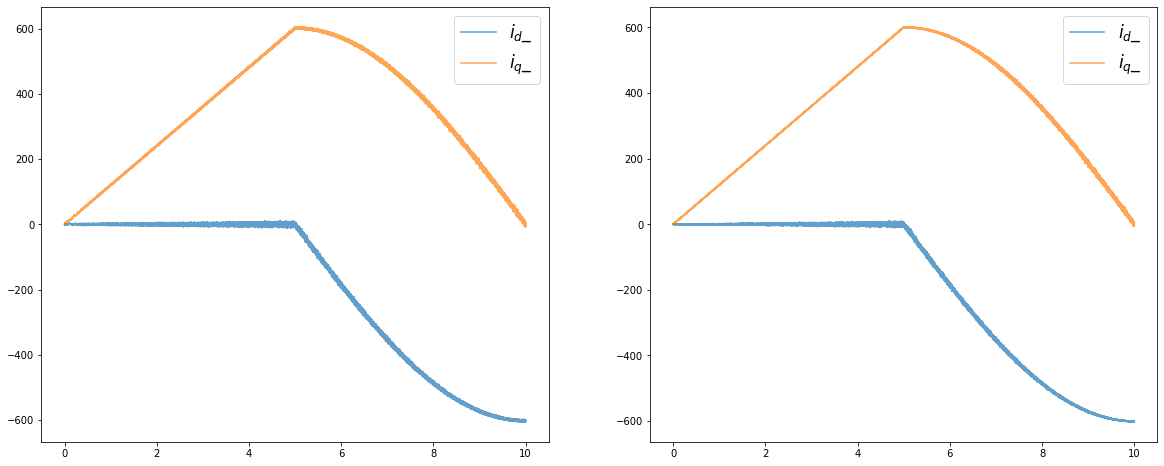

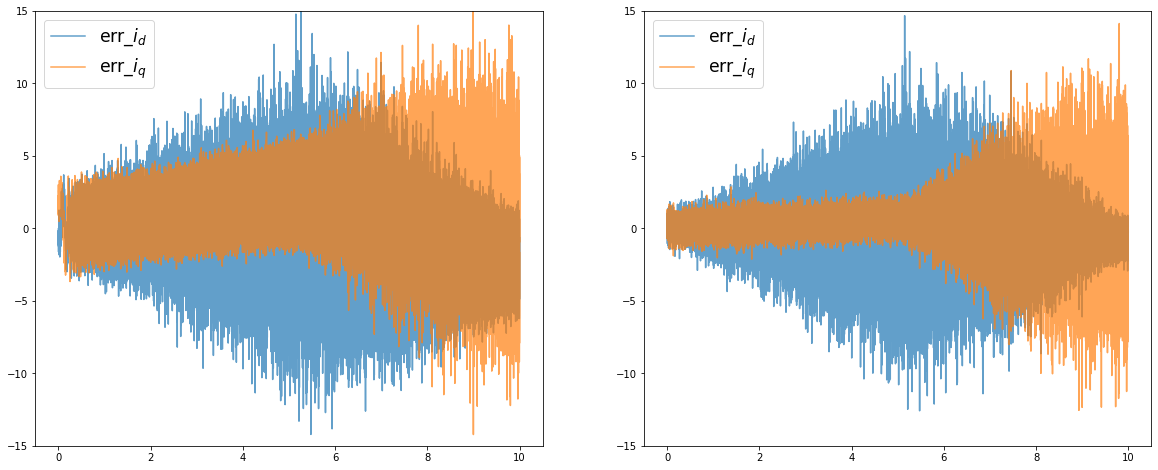

In [4]:
class AngleSensor():
    
    noise_std = (2*np.pi/360)/3
    
    def __init__(self):
        
        self.get_measurement = np.vectorize(self._get_measurement)
        
    def _get_measurement(self, true_angle):
        return true_angle + np.random.normal(0, self.noise_std)

as1 = AngleSensor()
theta = w*t
theta_ = theta
theta_ = as1.get_measurement(w*t)
#theta_ = as1.get_measurement(w*t - 2*np.pi/360*.2)

d =  np.cos(theta)*ialpha + np.sin(theta)*ibeta
q = -np.sin(theta)*ialpha + np.cos(theta)*ibeta

d_ =  np.cos(theta_)*ialpha_ + np.sin(theta_)*ibeta_
q_ = -np.sin(theta_)*ialpha_ + np.cos(theta_)*ibeta_

d_c =  np.cos(theta_)*ialpha_c + np.sin(theta_)*ibeta_c
q_c = -np.sin(theta_)*ialpha_c + np.cos(theta_)*ibeta_c

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, d_, label = r"$i_d$_", alpha=0.7)
ax.plot(t, q_, label = r"$i_q$_", alpha=0.7)
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(t, d_c, label = r"$i_d$_", alpha=0.7)
ax.plot(t, q_c, label = r"$i_q$_", alpha=0.7)
ax.legend()

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(t, d_ - d, label = r"err_$i_d$", alpha=0.7)
ax.plot(t, q_ - q, label = r"err_$i_q$", alpha=0.7)
ax.set_ylim(-15, 15)
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(t, d_c - d, label = r"err_$i_d$", alpha=0.7)
ax.plot(t, q_c - q, label = r"err_$i_q$", alpha=0.7)
ax.set_ylim(-15, 15)
ax.legend()